In [5]:
mode = "svg"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [6]:
import numpy as np
from graphbook_code import dcsbm

nk = 100  # 100 nodes per community
K = 3  # the number of communities
n = nk * K  # total number of nodes

zs = np.repeat(np.arange(K)+1, repeats=nk)
# block matrix and degree-correction factor
B = np.array([[0.7, 0.2, 0.1], [0.2, 0.5, 0.1], [0.1, 0.1, 0.4]])
theta = np.tile(np.linspace(start=0, stop=1, num=nk), reps=K)
# generate network sample
np.random.seed(0)
A = dcsbm(zs, theta, B)

# permute the nodes randomly
vtx_perm = np.random.choice(n, size=n, replace=False)
Aperm = A[vtx_perm, :][:,vtx_perm]
zperm = zs[vtx_perm]

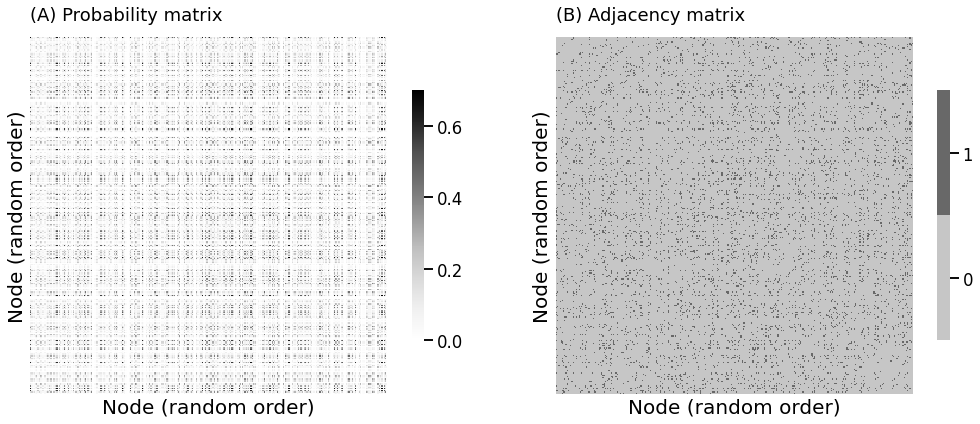

In [7]:
from graphbook_code import generate_dcsbm_pmtx, heatmap
import os

Pdcsbm_perm = generate_dcsbm_pmtx(zperm, theta[vtx_perm], B)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

heatmap(Pdcsbm_perm, ax=axs[0], title="(A) Probability matrix", xtitle="Node (random order)", ytitle="Node (random order)")
heatmap(Aperm.astype(int), ax=axs[1], title="(B) Adjacency matrix", xtitle="Node (random order)", ytitle="Node (random order)")

fig.tight_layout()

fname = "comm_detect_ex"
os.makedirs("Figures", exist_ok=True)
if mode != "png":
    os.makedirs(f"Figures/{mode:s}", exist_ok=True)
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

os.makedirs("Figures/png", exist_ok=True)
fig.savefig(f"Figures/png/{fname:s}.png")

In [8]:
import scipy as sp
from graspologic.embed import AdjacencySpectralEmbed as ase

Xhat = ase(n_components=3, svd_seed=0).fit_transform(Aperm)
D = sp.spatial.distance_matrix(Xhat, Xhat)

/usr/local/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


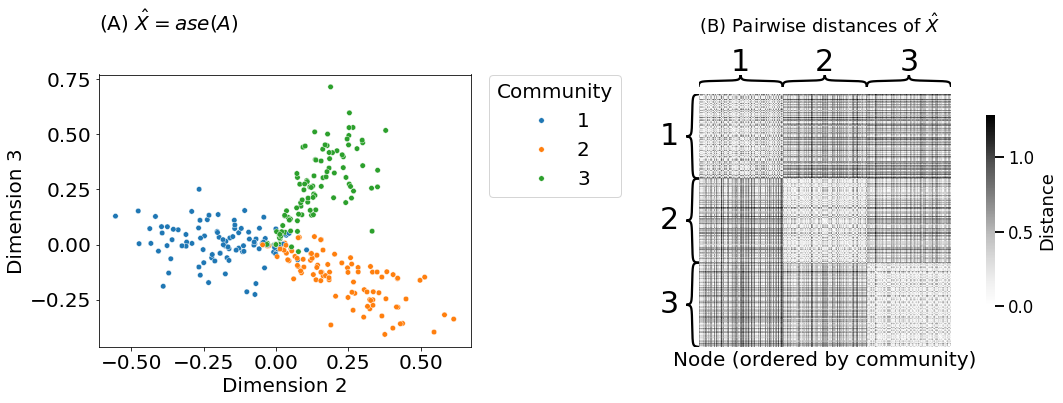

In [18]:
from graphbook_code import plot_latents
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

plot_latents(Xhat[:,1:3], labels=zperm,
            title="(A) $\\hat X = ase(A)$", ax=axs[0], s=30,
            xtitle="Dimension 2", ytitle="Dimension 3")
axs[0].set_title("(A) $\\hat X = ase(A)$", loc="left", pad=45, fontsize=20)
axs[0].legend(bbox_to_anchor=(1.05, 1), title="Community", loc='upper left', borderaxespad=0.)

heatmap(D, inner_hier_labels=zperm, title="(B) Pairwise distances of $\\hat X$",
        xtitle="Node (ordered by community)", ax=axs[1],
        legend_title="Distance")

fig.tight_layout()
fname = "comm_detect_embed"
if mode == "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [10]:
from sklearn.cluster import KMeans

labels_kmeans = KMeans(n_clusters = 3, random_state=0).fit_predict(Xhat)

In [11]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix between the true labels z
# and the predicted labels labels_kmeans
cf_matrix = confusion_matrix(zperm, labels_kmeans)

In [12]:

from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(zperm, labels_kmeans)
print(ari_kmeans)
# 0.490

0.4901452495709552


In [13]:
from graspologic.utils import remap_labels

labels_kmeans_remap = remap_labels(zperm, labels_kmeans)

# compute which assigned labels from labels_kmeans_remap differ from the true labels z
error = zperm - labels_kmeans_remap
# if the difference between the community labels is non-zero, an error has occurred
error = error != 0
error_rate = np.mean(error)  # error rate is the frequency of making an error

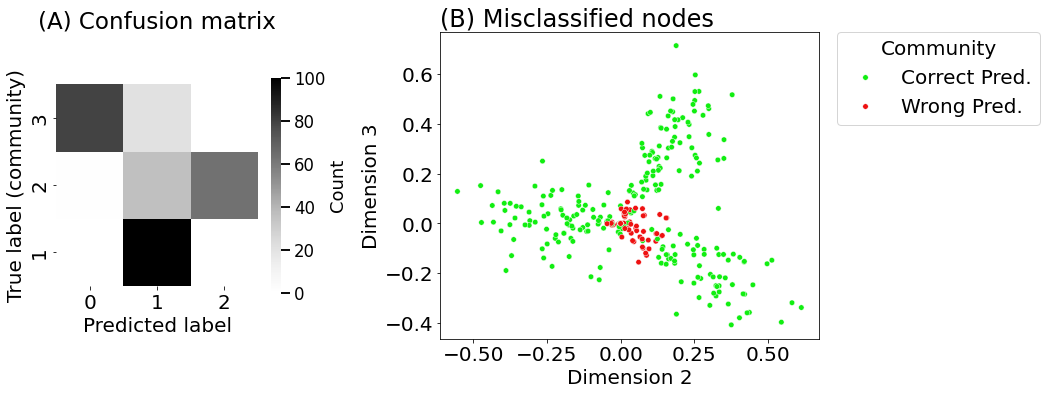

In [19]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"width_ratios": [1, 1.5]})

heatmap(cf_matrix.astype(float), yticks=[1.5, 2.5, 3.5], yticklabels=[1, 2, 3],
        xticks=[0.5, 1.5, 2.5], xticklabels=[0, 1, 2], xtitle="Predicted label",
        ytitle="True label (community)", title="", legend_title="Count", ax=axs[0])
axs[0].invert_yaxis()
axs[0].set_ylim((1, 4))
axs[0].set_xlim((0, 3))
axs[0].set_title("(A) Confusion matrix", pad=56, fontsize=23)

error_str = ["Correct Pred." if err == 0 else "Wrong Pred." for err in error]
plot_latents(Xhat[:,1:3], labels=error_str,
            title="(B) Misclassified nodes", ax=axs[1], s=30,
            palette={"Correct Pred.": "#11EE11", "Wrong Pred.": "#EE1111"},
            xtitle="Dimension 2", ytitle="Dimension 3")
axs[1].legend(bbox_to_anchor=(1.05, 1), title="Community", loc='upper left', borderaxespad=0.)

fig.tight_layout()
fname = "comm_detect_eval"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")

In [25]:
Xhat = ase(svd_seed=0).fit_transform(Aperm)
print("Estimated number of dimensions: {:d}".format(Xhat.shape[1]))
# Estimated number of dimensions: 3

/usr/local/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


Estimated number of dimensions: 3


In [26]:
from graspologic.cluster import KMeansCluster

km_clust = KMeansCluster(max_clusters = 10, random_state=0)
labels_kmclust = km_clust.fit_predict(Xhat)

In [27]:
import seaborn as sns
from pandas import DataFrame as df

nclusters = range(2, 11)  # graspologic nclusters goes from 2 to max_clusters
silhouette = km_clust.silhouette_ # obtain the respective silhouettes

# place into pandas dataframe
ss_df = df({"Number of Communities": nclusters, "Silhouette Score": silhouette})

In [28]:
# compute the confusion matrix between the true labels z
# and the predicted labels labels_kmeans
cf_matrix_kmclust = confusion_matrix(zperm, labels_kmclust)

labels_kmeans_remap_kmclust = remap_labels(zperm, labels_kmeans)

# compute which assigned labels from labels_kmeans_remap differ from the true labels z
error_kmclust = zperm - labels_kmeans_remap_kmclust
# if the difference between the community labels is non-zero, an error has occurred
error_kmclust = error_kmclust != 0
error_rate_kmclust = np.mean(error_kmclust)  # error rate is the frequency of making an error

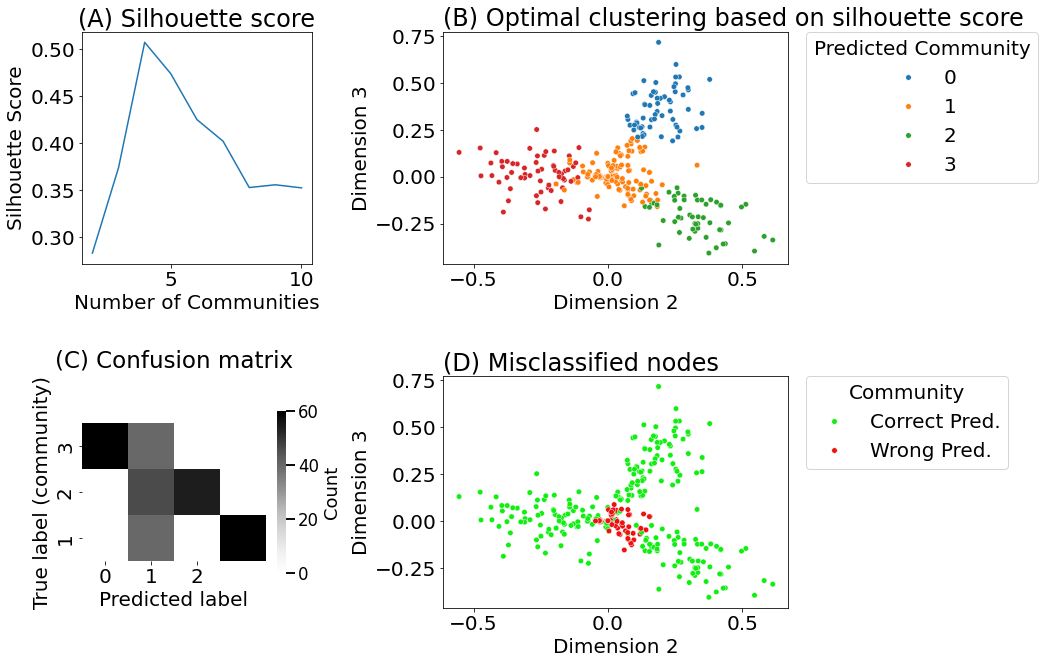

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), gridspec_kw={"width_ratios": [1, 1.5]})
sns.lineplot(data=ss_df, x="Number of Communities", y="Silhouette Score", ax=axs[0][0])
axs[0][0].set_title("(A) Silhouette score")

plot_latents(Xhat[:,1:3], labels=labels_kmclust,
            title="(B) Optimal clustering based on silhouette score", ax=axs[0][1], s=30)
axs[0][1].set_xlabel("Dimension 2")
axs[0][1].set_ylabel("Dimension 3")
axs[0][1].legend(bbox_to_anchor=(1.05, 1), title="Predicted Community", loc='upper left', borderaxespad=0.)

heatmap(cf_matrix_kmclust.astype(float), yticks=[1.5, 2.5, 3.5], yticklabels=[1, 2, 3],
        xticks=[0.5, 1.5, 2.5], xticklabels=[0, 1, 2], xtitle="Predicted label",
        ytitle="True label (community)", title="", legend_title="Count", ax=axs[1][0])
axs[1][0].invert_yaxis()
axs[1][0].set_ylim((1, 4))
axs[1][0].set_xlim((0, 4))
axs[1][0].set_title("(C) Confusion matrix", pad=56, fontsize=23)

error_str = ["Correct Pred." if err == 0 else "Wrong Pred." for err in error_kmclust]
plot_latents(Xhat[:,1:3], labels=error_str,
            title="(D) Misclassified nodes", ax=axs[1][1], s=30,
            palette={"Correct Pred.": "#11EE11", "Wrong Pred.": "#EE1111"},
            xtitle="Dimension 2", ytitle="Dimension 3")
axs[1][1].legend(bbox_to_anchor=(1.05, 1), title="Community", loc='upper left', borderaxespad=0.)

fig.tight_layout()

fname = "comm_detect_kmclust"
if mode != "png":
    fig.savefig(f"Figures/{mode:s}/{fname:s}.{mode:s}")

fig.savefig(f"Figures/png/{fname:s}.png")